In [45]:
import os
os.chdir('/media/abhishek/DATA/open_source/pyshbundle')
import pyshbundle
from tqdm import trange
from datetime import datetime

from pyshbundle.new_io import read_jpl, read_csr, read_tn13, read_tn14, extract_C10_11_replcmnt_coeff, cklm2sc_new
from pyshbundle.new_io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, replace_zonal_coeff, find_date_in_replacemnt_file
from pyshbundle.new_io import read_itsg

import numpy as np

In [46]:
path_sh = '/media/abhishek/DATA/open_source/pyshbundle/sample_input_data/JPL_input'
path_tn13_jpl = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt'
path_tn14_jpl = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt'
source = 'jpl'

file_name = "GSM-2_2002094-2002120_GRAC_JPLEM_BB01_0600.gz"
file_path = path_sh + '/' + file_name


## Reading all the JPL files

In [47]:
# loading all the JPL files
files = os.listdir(path_sh)
data_mat_jpl = np.ndarray((len(files), 4750, 6))
# For more systematic arranging - check the 

# collecting all the begin and stop dates in a matrix
# later on can be converted to datetime object as and when required
dates_jpl = np.ndarray((len(files), 2))
for i in trange(len(files)):
    file_path = path_sh + '/' + files[i]
    header = read_jpl(file_path)[0]
    data_mat_jpl[i, :, :] = read_jpl(file_path)[1]
    dates_jpl[i, 0] = float(str(read_jpl(file_path)[2])[1:-1])
    dates_jpl[i, 1] = float(str(read_jpl(file_path)[3])[1:-1])
    

100%|██████████| 201/201 [00:30<00:00,  6.62it/s]


In [6]:
header

{'title': 'GRACE-FO Geopotential Coefficients JPL RL06.1',
 'institution': 'NASA/JPL',
 'product_version': '6.1',
 'processing_level': '2',
 'normalization': 'fully normalized',
 'permanent_tide_flag': 'inclusive permanent tide',
 'degree': 96,
 'order': 96,
 'earth_gravity_param': {'units': 'm3/s2', 'value': 398600441500000.0},
 'mean_equator_radius': {'units': 'meters', 'value': 6378136.3}}

In [57]:
data_mat_jpl[59, :, :][0:9]

array([[ 2.00000000e+00,  0.00000000e+00, -4.84169399e-04,
         0.00000000e+00,  1.03830000e-11,  0.00000000e+00],
       [ 2.00000000e+00,  1.00000000e+00, -2.62846554e-10,
         1.45725684e-09,  3.73210000e-12,  3.35030000e-12],
       [ 2.00000000e+00,  2.00000000e+00,  2.43940577e-06,
        -1.40024112e-06,  1.18350000e-12,  1.16970000e-12],
       [ 3.00000000e+00,  0.00000000e+00,  9.57131203e-07,
         0.00000000e+00,  1.48280000e-12,  0.00000000e+00],
       [ 3.00000000e+00,  1.00000000e+00,  2.03047037e-06,
         2.48192504e-07,  9.24410000e-13,  9.02080000e-13],
       [ 3.00000000e+00,  2.00000000e+00,  9.04787365e-07,
        -6.19037353e-07,  1.22460000e-12,  1.22980000e-12],
       [ 3.00000000e+00,  3.00000000e+00,  7.21329376e-07,
         1.41436032e-06,  2.40560000e-12,  2.39060000e-12],
       [ 4.00000000e+00,  0.00000000e+00,  5.40019391e-07,
         0.00000000e+00,  6.03310000e-13,  0.00000000e+00],
       [ 4.00000000e+00,  1.00000000e+00, -5.361

In [58]:
dates_jpl[0:9]

array([[20020404., 20020501.],
       [20020502., 20020519.],
       [20020801., 20020901.],
       [20020901., 20021001.],
       [20021001., 20021101.],
       [20021101., 20021201.],
       [20021201., 20030101.],
       [20030101., 20030201.],
       [20030201., 20030301.]])

In [48]:
data_tn13_jpl = read_tn13(path_tn13_jpl)


In [26]:
data_tn13_jpl[0, :]

array([1.00000000e+00, 0.00000000e+00, 4.93509151e-10, 0.00000000e+00,
       4.45850000e-11, 0.00000000e+00, 2.00204040e+07, 2.00205010e+07])

In [49]:
data_tn14_jpl = read_tn14(path_tn14_jpl)

In [50]:
from copy import deepcopy
def replace_zonal_coeff(data_mat, source, lmax, data_tn13, data_tn14, epoch_begin: float, epoch_end: float):

    data_mat_copy = deepcopy(data_mat)

    if source == 'jpl':
        assert epoch_end is not None, "epoch_end argument cannot be None"
        # convert the float YYYYMMDD into datetime.date object
        epoch_begin = datetime.strptime(str(int(epoch_begin)), '%Y%m%d').date()
        epoch_end = datetime.strptime(str(int(epoch_end)), '%Y%m%d').date()

        # Extract the C10, C11, C20 and C30 from TN-13 and TN-14
        C10, C11 = extract_C10_11_replcmnt_coeff(data_tn13, 'jpl', epoch_begin, epoch_end)
        C20 = extract_C20_replcmnt_coeff(data_tn14, source, epoch_begin, epoch_end)
        C30 = extract_C30_replcmnt_coeff(data_tn14, source, epoch_begin, epoch_end)

        # For easy replacement purpose
        C00 = np.array([0, 0, 1, 0, 0, 0])
        C00_10_11 = np.array([C00, C10, C11])

        # C30 is  at index - 3 in original matrix
        data_mat_copy[3, :] = C30

        # C20 is at index - 0 in original matrix
        data_mat_copy[0, :] = C20

        # stack the matrix row-wise
        data_mat_copy = np.row_stack([C00_10_11, data_mat_copy])
    
    elif source == 'csr':
        epoch_begin = datetime.strptime(str(int(epoch_begin)), '%Y%m%d').date()
        epoch_end = datetime.strptime(str(int(epoch_end)), '%Y%m%d').date()

        C10, C11 = extract_C10_11_replcmnt_coeff(data_tn13, 'csr', epoch_begin, epoch_end)

        C20 = extract_C20_replcmnt_coeff(data_tn14, 'csr', epoch_begin, epoch_end)
        C30 = extract_C30_replcmnt_coeff(data_tn14, 'csr', epoch_begin, epoch_end)

        # C10 is at index - 1
        # C20 is at index - 2
        # C30 is at index - 3
        # C11 is at index - lmax + 1
        data_mat_copy[lmax+1,:] = C11
        data_mat_copy[3, :] = C30
        data_mat_copy[2, :] = C20
        data_mat_copy[1, :] = C10

    elif source == 'itsg':
        # the CSR dates are strings to begin with
        begin_date = datetime.strptime((epoch_begin), '%Y-%m').date()

        C10, C11 = extract_C10_11_replcmnt_coeff(data_tn13, 'csr', f"{begin_date.year}-{str(begin_date.month).zfill(2)}", epoch_end=None)

        C20 = extract_C20_replcmnt_coeff(data_tn14, 'csr', f"{begin_date.year}-{str(begin_date.month).zfill(2)}", epoch_end=None)
        C30 = extract_C30_replcmnt_coeff(data_tn14, 'csr', f"{begin_date.year}-{str(begin_date.month).zfill(2)}", epoch_end=None)

        # For easy replacement purpose
        # C10 is at index 1
        # C11 is at index 2
        # C20 is at index 3
        # C30 is at index 6
        data_mat_copy[6, :] = C30
        data_mat_copy[3, :] = C20
        data_mat_copy[2, :] = C11
        data_mat_copy[1, :] = C10
            
    return data_mat_copy

In [51]:
#replace_zonal_coeff(data_mat, data_tn13, data_tn14, epoch_begin, epoch_end)
# Replace zonal coeff
replaced_data_mat_jpl = np.ndarray((len(files), 4753, 6))

for i in trange(len(files)):
    try:
        replaced_data_mat_jpl[i, :, :] = replace_zonal_coeff(data_mat_jpl[i, :, :], 'jpl', 96, data_tn13_jpl, data_tn14_jpl, dates_jpl[i][0], dates_jpl[i][1])
    except IndexError:
        print(f"Replacement data for File Index {i} - {dates_jpl[i][0], dates_jpl[i][1]} could not be found.... procedding to next file")


100%|██████████| 201/201 [00:01<00:00, 115.39it/s]

Replacement data for File Index 196 - (20220201.0, 20220301.0) could not be found.... procedding to next file
Replacement data for File Index 197 - (20220301.0, 20220401.0) could not be found.... procedding to next file
Replacement data for File Index 198 - (20220401.0, 20220501.0) could not be found.... procedding to next file
Replacement data for File Index 199 - (20220501.0, 20220601.0) could not be found.... procedding to next file
Replacement data for File Index 200 - (20220601.0, 20220701.0) could not be found.... procedding to next file


From the last date of TN-14 seems like its Jan-2022 whereas for JPL data the final dates are for Feb-2022 and beyond

In [8]:
import julian
julian.from_jd(data_tn14_jpl[-1][-2], fmt='mjd').date(), julian.from_jd(data_tn14_jpl[-1][-1], fmt='mjd').date()


(datetime.date(2022, 1, 1), datetime.date(2022, 2, 1))

### CLM to SC format conversion

In [52]:
scmat_deck = np.ndarray((196, 97, 193))
devscmat_deck = np.ndarray((196, 97, 193))

for i in trange(196):
    scmat_deck[i, :, :], devscmat_deck[i, :, :] = cklm2sc_new(replaced_data_mat_jpl[i], lmax=96)
    

100%|██████████| 196/196 [00:00<00:00, 4299.02it/s]


### Plot the scmatrix

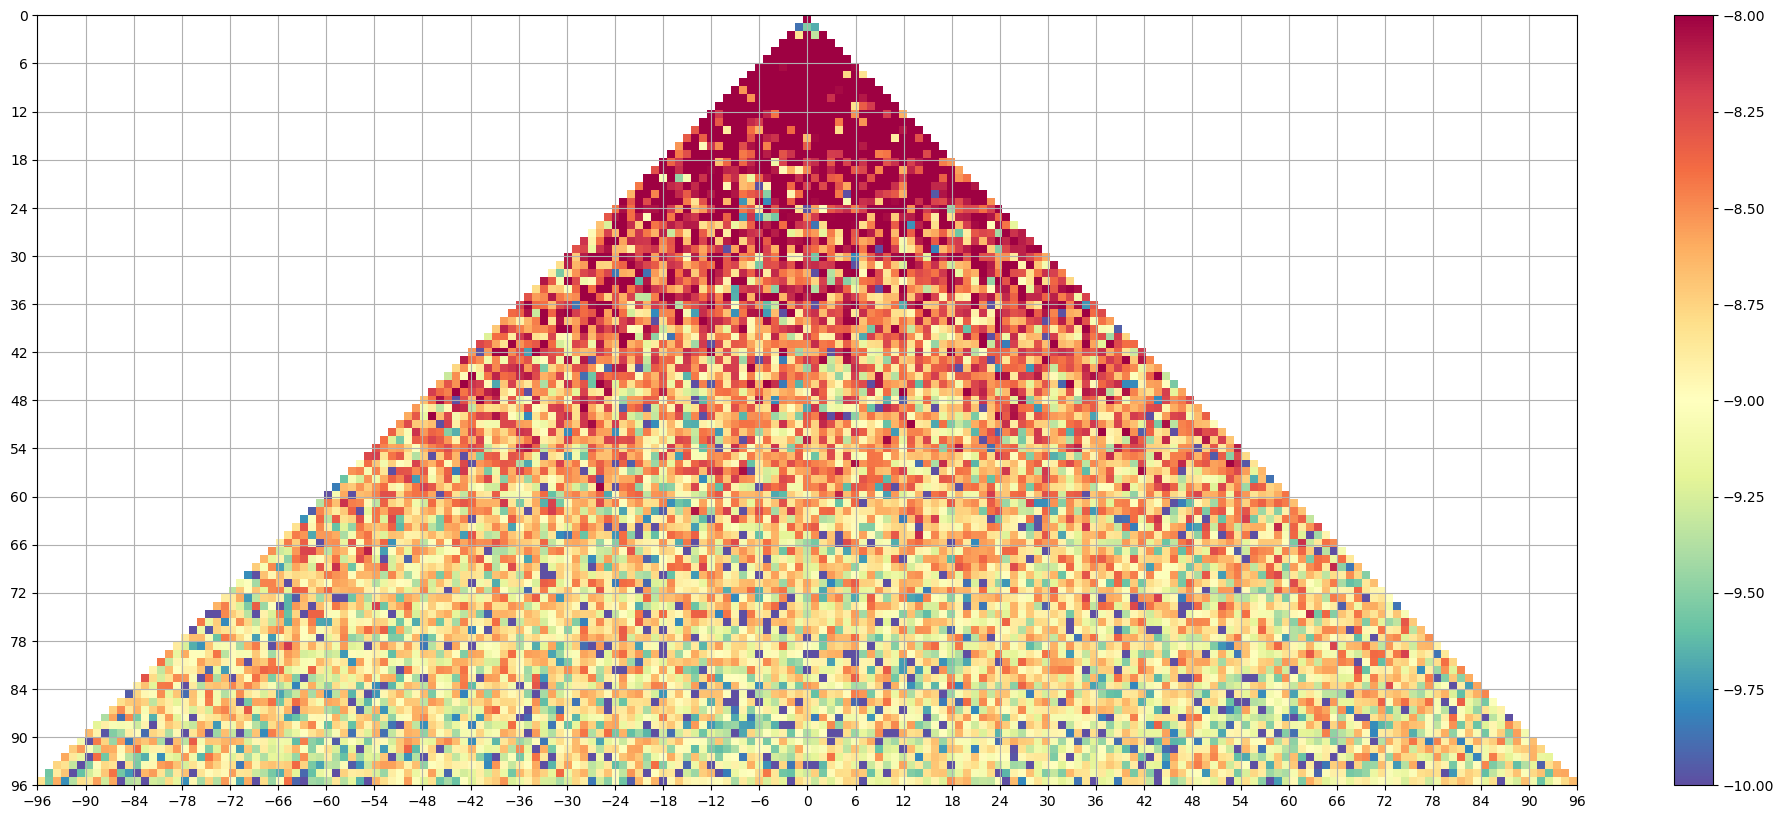

In [56]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(scmat_deck[145])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-10, vmax=-8)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.show()

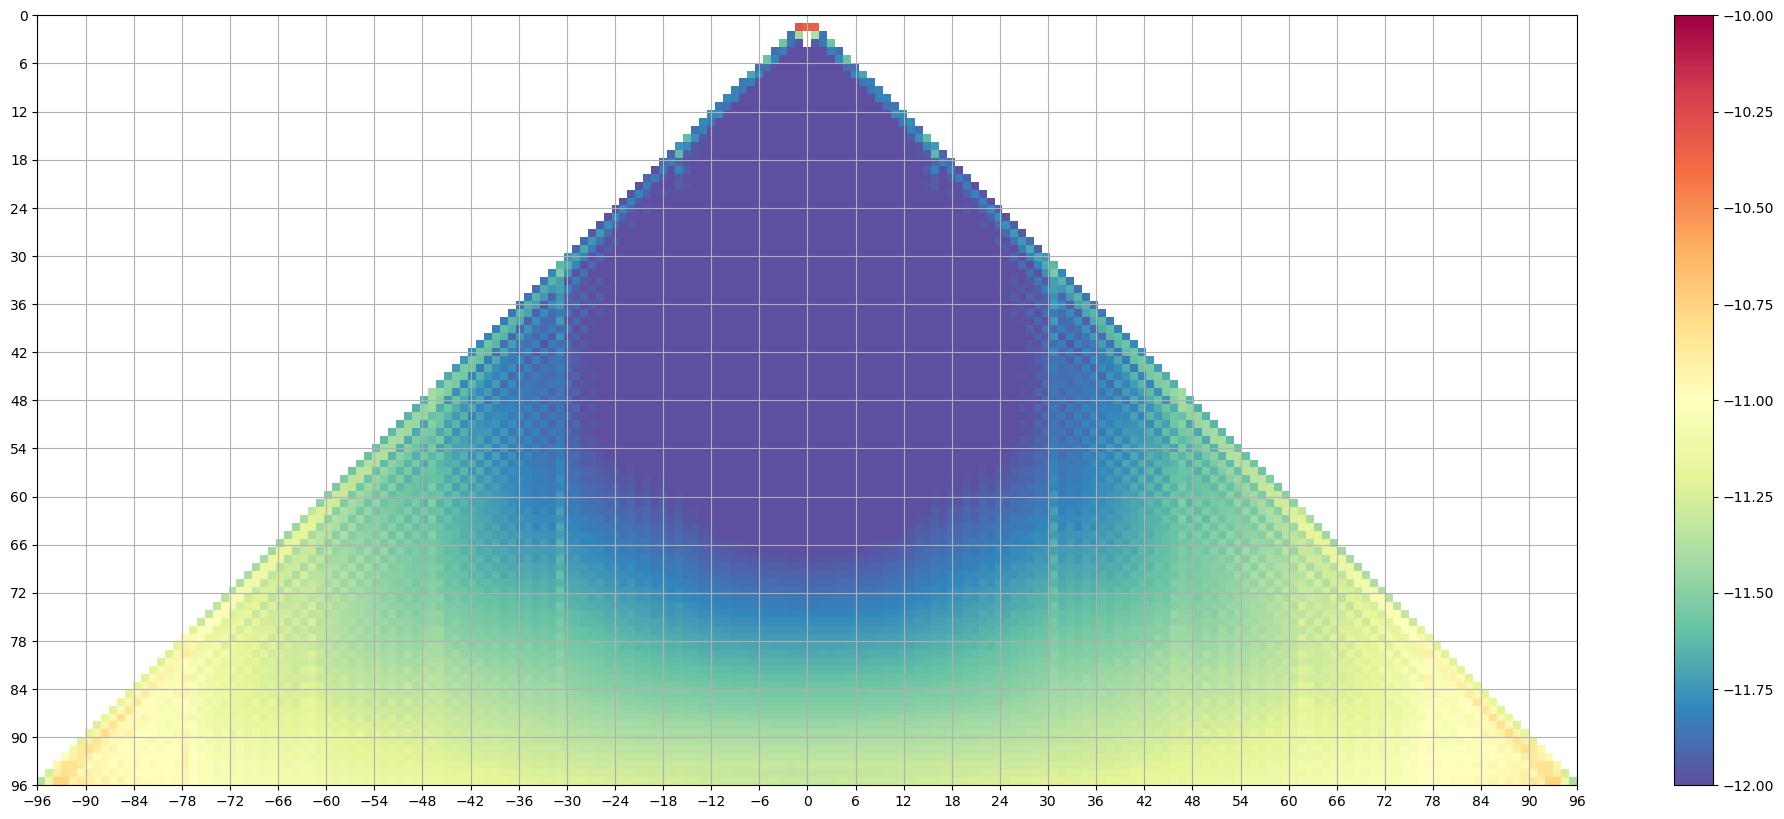

In [55]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck[145])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.show()

# Testing CSR

In [61]:
tn14_path_csr = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/CSR_TN_files/TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_csr = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/CSR_TN_files/TN-13_GEOC_CSR_RL06.1.txt'
csr_folder = '/media/abhishek/DATA/open_source/pyshbundle/sample_input_data/CSR_input'


In [62]:
# Loading all the CSR Files

files = os.listdir(csr_folder)
data_csr_mat = np.ndarray((len(files), 4753, 6))
dates_csr = np.ndarray((len(files), 2))
for i in trange(len(files)):
    file_path = csr_folder + '/' + files[i]
    header_csr = read_csr(file_path)[0]
    data_csr_mat[i, :, :] = read_csr(file_path)[1]
    dates_csr[i, 0] = float(str(read_csr(file_path)[2])[1:-1])
    dates_csr[i, 1] = float(str(read_csr(file_path)[3])[1:-1])

100%|██████████| 212/212 [00:33<00:00,  6.38it/s]


In [63]:
header_csr

{'title': 'GRACE-FO Geopotential Coefficients CSR RL06.1',
 'institution': 'UT-AUSTIN/CSR',
 'product_version': 'RL06.1',
 'processing_level': '2',
 'normalization': 'fully normalized',
 'permanent_tide_flag': 'inclusive',
 'degree': 96,
 'order': 96,
 'earth_gravity_param': {'units': 'm3/s2', 'value': 398600441500000.0},
 'mean_equator_radius': {'units': 'meters', 'value': 6378136.3}}

In [65]:
data_csr_mat[79, :, :][0:5]

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00, -4.84169370e-04,
         0.00000000e+00,  3.91800000e-13,  0.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  9.57249030e-07,
         0.00000000e+00,  2.86500000e-13,  0.00000000e+00],
       [ 4.00000000e+00,  0.00000000e+00,  5.40016567e-07,
         0.00000000e+00,  2.90400000e-13,  0.00000000e+00]])

In [66]:
dates_csr[0:5]

array([[20020405., 20020501.],
       [20020503., 20020518.],
       [20020801., 20020901.],
       [20020901., 20021001.],
       [20021001., 20021101.]])

In [26]:
data_tn13_csr = read_tn13(tn_13_path_csr)


In [27]:
data_tn14_csr = read_tn14(tn14_path_csr)

In [34]:
#replace_zonal_coeff(data_mat, data_tn13, data_tn14, epoch_begin, epoch_end)
# Replace zonal coeff
replaced_data_mat_csr = np.ndarray((len(files), 4753, 6))

unreplaced_idx = set()
for i in trange(len(files)):
    try:
        replaced_data_mat_csr[i, :, :] = replace_zonal_coeff(data_csr_mat[i, :, :], 'csr', 96, data_tn13_csr, data_tn14_csr, dates_csr[i][0], dates_csr[i][1])
    except IndexError:
        print(f"Replacement data for File Index {i} - {dates_csr[i][0], dates_csr[i][1]} could not be found.... procedding to next file")
        unreplaced_idx.add(i)

unreplaced_idx = list(unreplaced_idx)

  8%|▊         | 17/212 [00:00<00:02, 81.94it/s]

Replacement data for File Index 0 - (20020405.0, 20020501.0) could not be found.... procedding to next file
Replacement data for File Index 1 - (20020503.0, 20020518.0) could not be found.... procedding to next file
Replacement data for File Index 14 - (20031001.0, 20031101.0) could not be found.... procedding to next file


 27%|██▋       | 58/212 [00:00<00:01, 93.71it/s]

Replacement data for File Index 43 - (20140303.0, 20140401.0) could not be found.... procedding to next file


 37%|███▋      | 79/212 [00:00<00:01, 95.38it/s]

Replacement data for File Index 67 - (20070201.0, 20070228.0) could not be found.... procedding to next file


 63%|██████▎   | 133/212 [00:01<00:00, 100.97it/s]

Replacement data for File Index 117 - (20111016.0, 20111116.0) could not be found.... procedding to next file
Replacement data for File Index 118 - (20111213.0, 20120112.0) could not be found.... procedding to next file
Replacement data for File Index 121 - (20120320.0, 20120419.0) could not be found.... procedding to next file
Replacement data for File Index 125 - (20120901.0, 20120926.0) could not be found.... procedding to next file
Replacement data for File Index 136 - (20140101.0, 20140117.0) could not be found.... procedding to next file


 73%|███████▎  | 154/212 [00:01<00:00, 89.46it/s] 

Replacement data for File Index 143 - (20141101.0, 20141201.0) could not be found.... procedding to next file
Replacement data for File Index 151 - (20151211.0, 20160104.0) could not be found.... procedding to next file


 82%|████████▏ | 173/212 [00:01<00:00, 80.59it/s]

Replacement data for File Index 163 - (20170503.0, 20170523.0) could not be found.... procedding to next file
Replacement data for File Index 164 - (20170523.0, 20170629.0) could not be found.... procedding to next file
Replacement data for File Index 170 - (20190126.0, 20190307.0) could not be found.... procedding to next file


100%|██████████| 212/212 [00:02<00:00, 89.31it/s]


In [35]:
scmat_deck_csr = np.ndarray((len(files), 97, 193))
devscmat_deck_csr = np.ndarray((len(files), 97, 193))

for i in trange(196):
    if i not in unreplaced_idx:
        scmat_deck_csr[i, :, :], devscmat_deck_csr[i, :, :] = cklm2sc_new(replaced_data_mat_csr[i], lmax=96)
    
    

100%|██████████| 196/196 [00:00<00:00, 1867.69it/s]


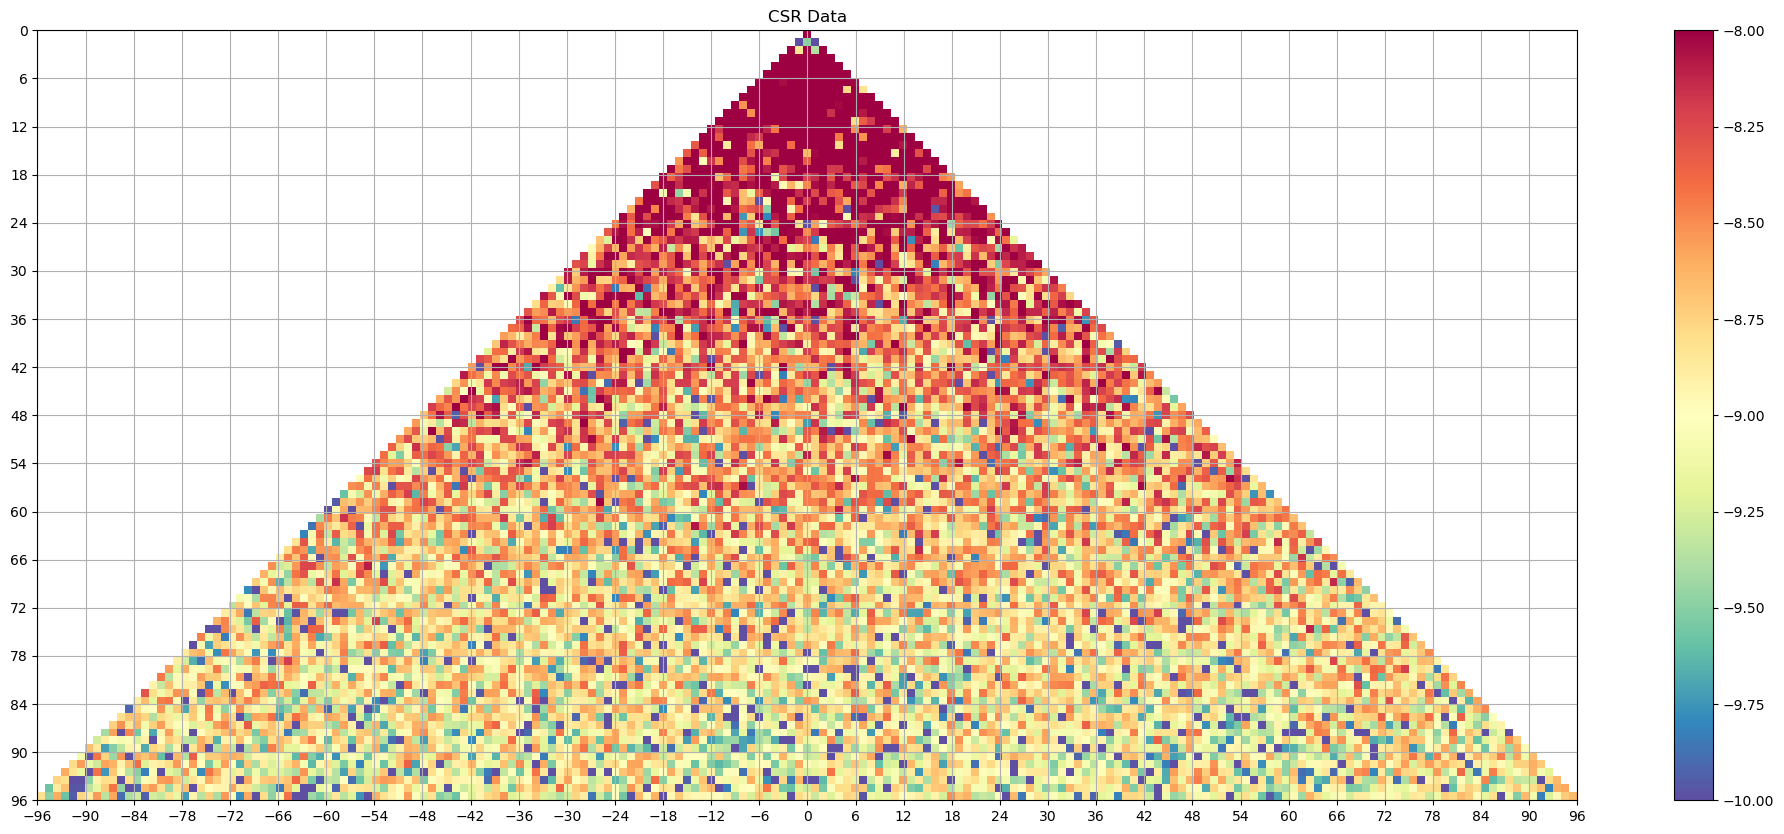

In [60]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(scmat_deck_csr[144])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-10, vmax=-8)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title("CSR Data")
plt.show()

### Why some decviations show this weird pattern?

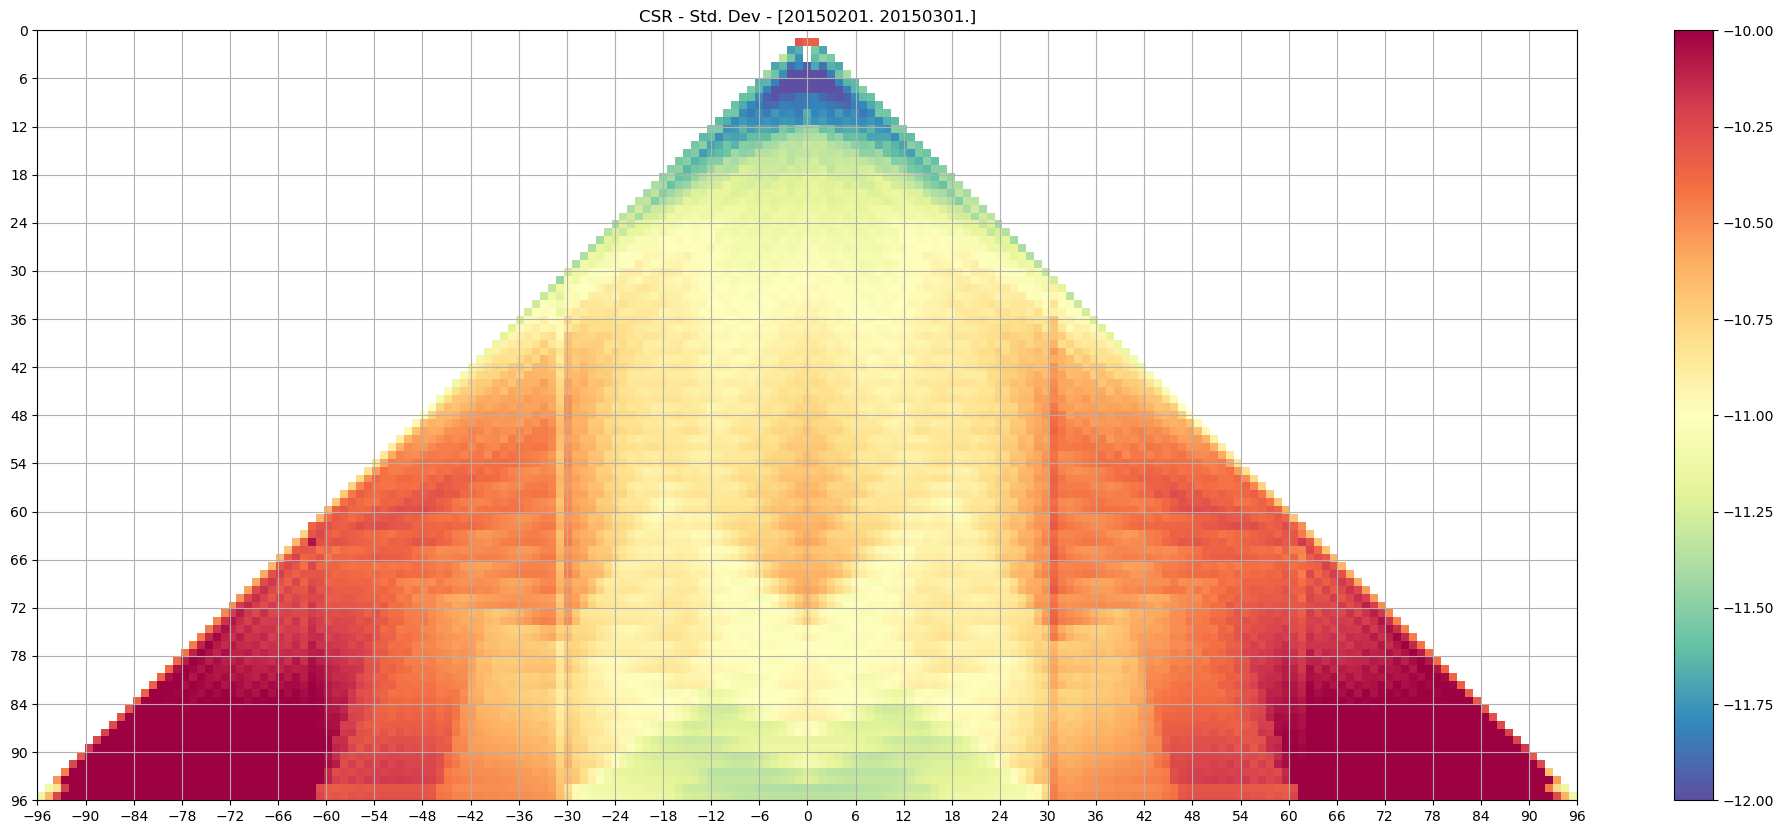

In [49]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_csr[145])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_csr[145]}")
plt.show()

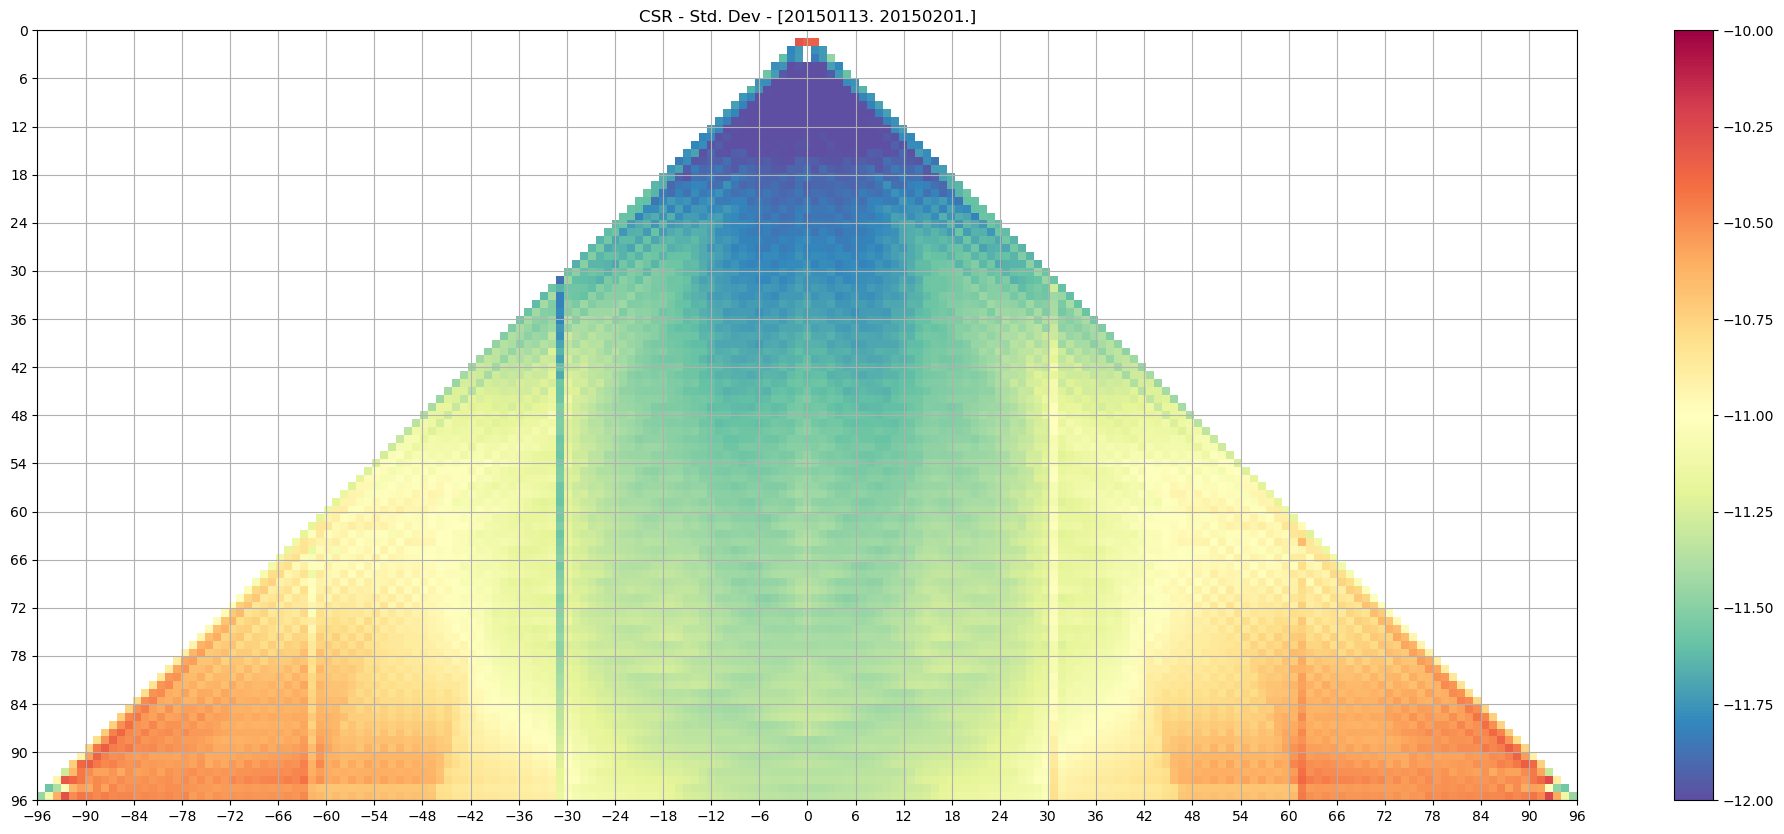

In [78]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_csr[144])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_csr[144]}")
plt.show()

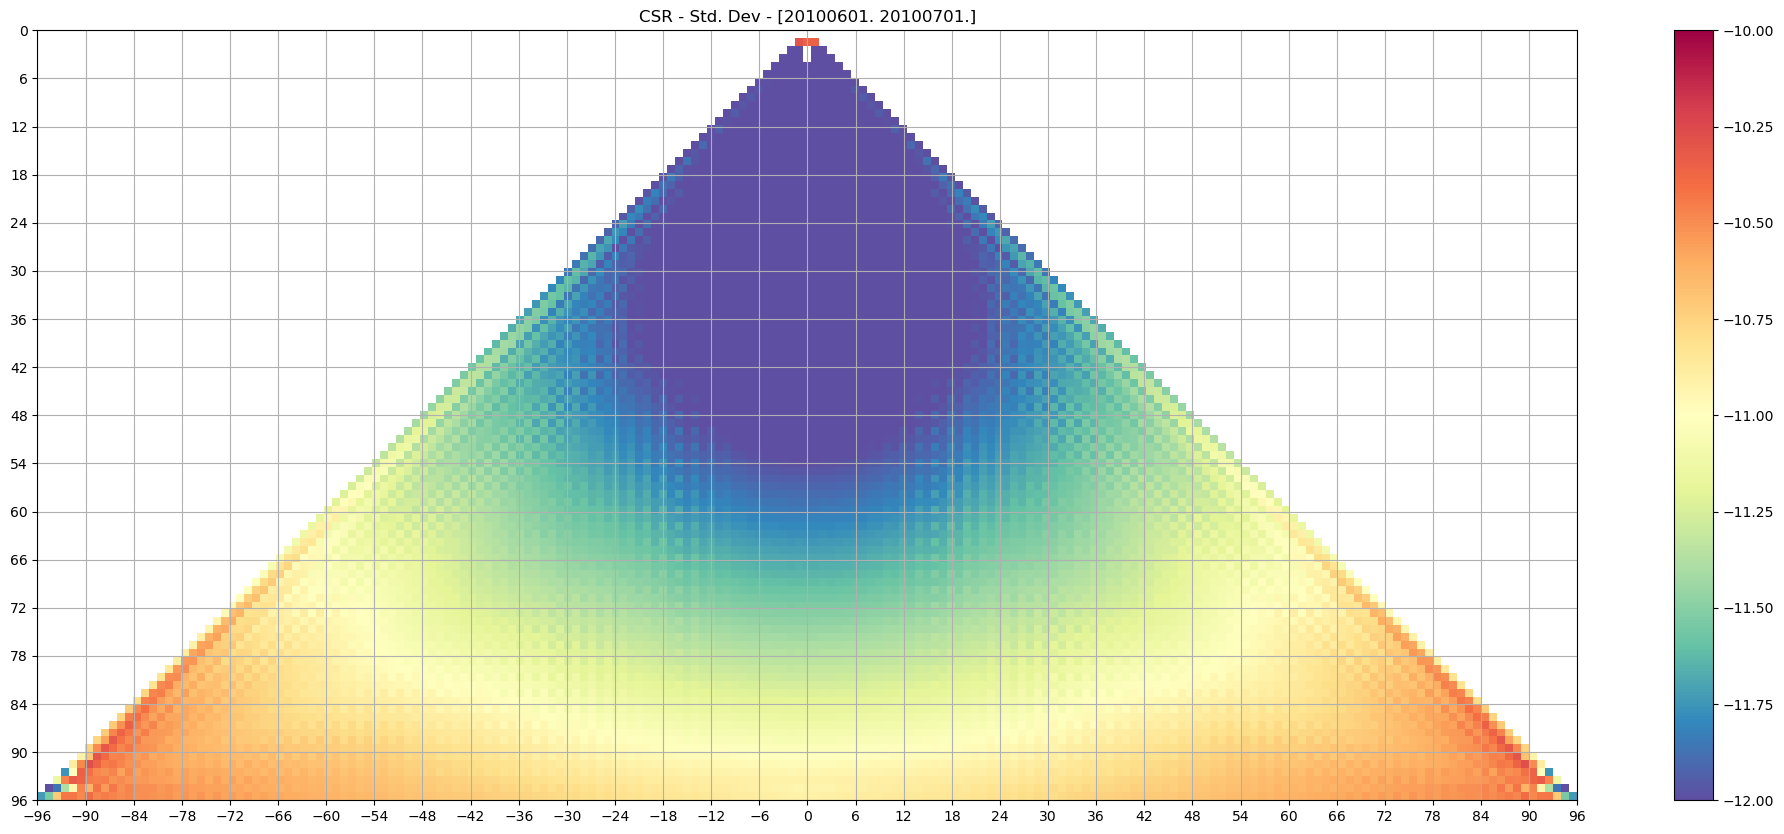

In [87]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_csr[40])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_csr[40]}")
plt.show()

In [86]:
data_csr_mat[40][96*30+5]

array([5.90000000e+01, 3.60000000e+01, 4.39216695e-10, 9.92317184e-10,
       3.34400000e-12, 3.35600000e-12])

In [82]:
np.log10(abs(9.96e-10))

-9.001740661576301

# Testing ITSG

In [3]:
tn14_path_itsg = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/ITSG_TN_files/TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_itsg = '/media/abhishek/DATA/open_source/pyshbundle/pyshbundle/data/ITSG_TN_files/TN-13_GEOC_CSR_RL06.1.txt'
itsg_folder = '/media/abhishek/DATA/open_source/pyshbundle/sample_input_data/ITSG_input'


In [11]:
# load all the itsg files
files = os.listdir(itsg_folder)
data_itsg_mat = np.ndarray((len(files), 4753, 6))
dates_itsg = []
for i in trange(len(files)):
    file_path = itsg_folder + '/' + files[i]
    header = read_itsg(file_path)[0]
    data_itsg_mat[i, :, :] = read_itsg(file_path)[1]
    dates_itsg.append(read_itsg(file_path)[2])

100%|██████████| 214/214 [00:19<00:00, 11.18it/s]


In [5]:
data_tn13_itsg = read_tn13(tn_13_path_itsg)
data_tn14_itsg = read_tn14(tn14_path_itsg)


In [16]:
#replace_zonal_coeff(data_mat, data_tn13, data_tn14, epoch_begin, epoch_end)
# Replace zonal coeff
replaced_data_mat_itsg = np.ndarray((len(files), 4753, 6))

unreplaced_idx = set()
for i in trange(len(files)):
    try:
        replaced_data_mat_itsg[i, :, :] = replace_zonal_coeff(data_itsg_mat[i, :, :], 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg[i], epoch_end=None)
    except IndexError:
        print(f"Replacement data for File Index {i} - {dates_itsg[i]} could not be found.... procedding to next file")
        unreplaced_idx.add(i)

unreplaced_idx = list(unreplaced_idx)

 64%|██████▍   | 138/214 [00:01<00:00, 86.20it/s]

Replacement data for File Index 117 - 2011-11 could not be found.... procedding to next file
Replacement data for File Index 121 - 2012-04 could not be found.... procedding to next file


 73%|███████▎  | 156/214 [00:01<00:00, 86.66it/s]

Replacement data for File Index 148 - 2015-07 could not be found.... procedding to next file
Replacement data for File Index 153 - 2016-02 could not be found.... procedding to next file


 81%|████████▏ | 174/214 [00:02<00:00, 74.69it/s]

Replacement data for File Index 164 - 2017-06 could not be found.... procedding to next file
Replacement data for File Index 170 - 2019-02 could not be found.... procedding to next file


100%|██████████| 214/214 [00:02<00:00, 86.29it/s]

Replacement data for File Index 212 - 2022-10 could not be found.... procedding to next file
Replacement data for File Index 213 - 2022-11 could not be found.... procedding to next file


In [18]:
scmat_deck_itsg = np.ndarray((len(files), 97, 193))
devscmat_deck_itsg = np.ndarray((len(files), 97, 193))

for i in trange(196):
    if i not in unreplaced_idx:
        scmat_deck_itsg[i, :, :], devscmat_deck_itsg[i, :, :] = cklm2sc_new(replaced_data_mat_itsg[i], lmax=96)
    
    

100%|██████████| 196/196 [00:00<00:00, 2997.71it/s]


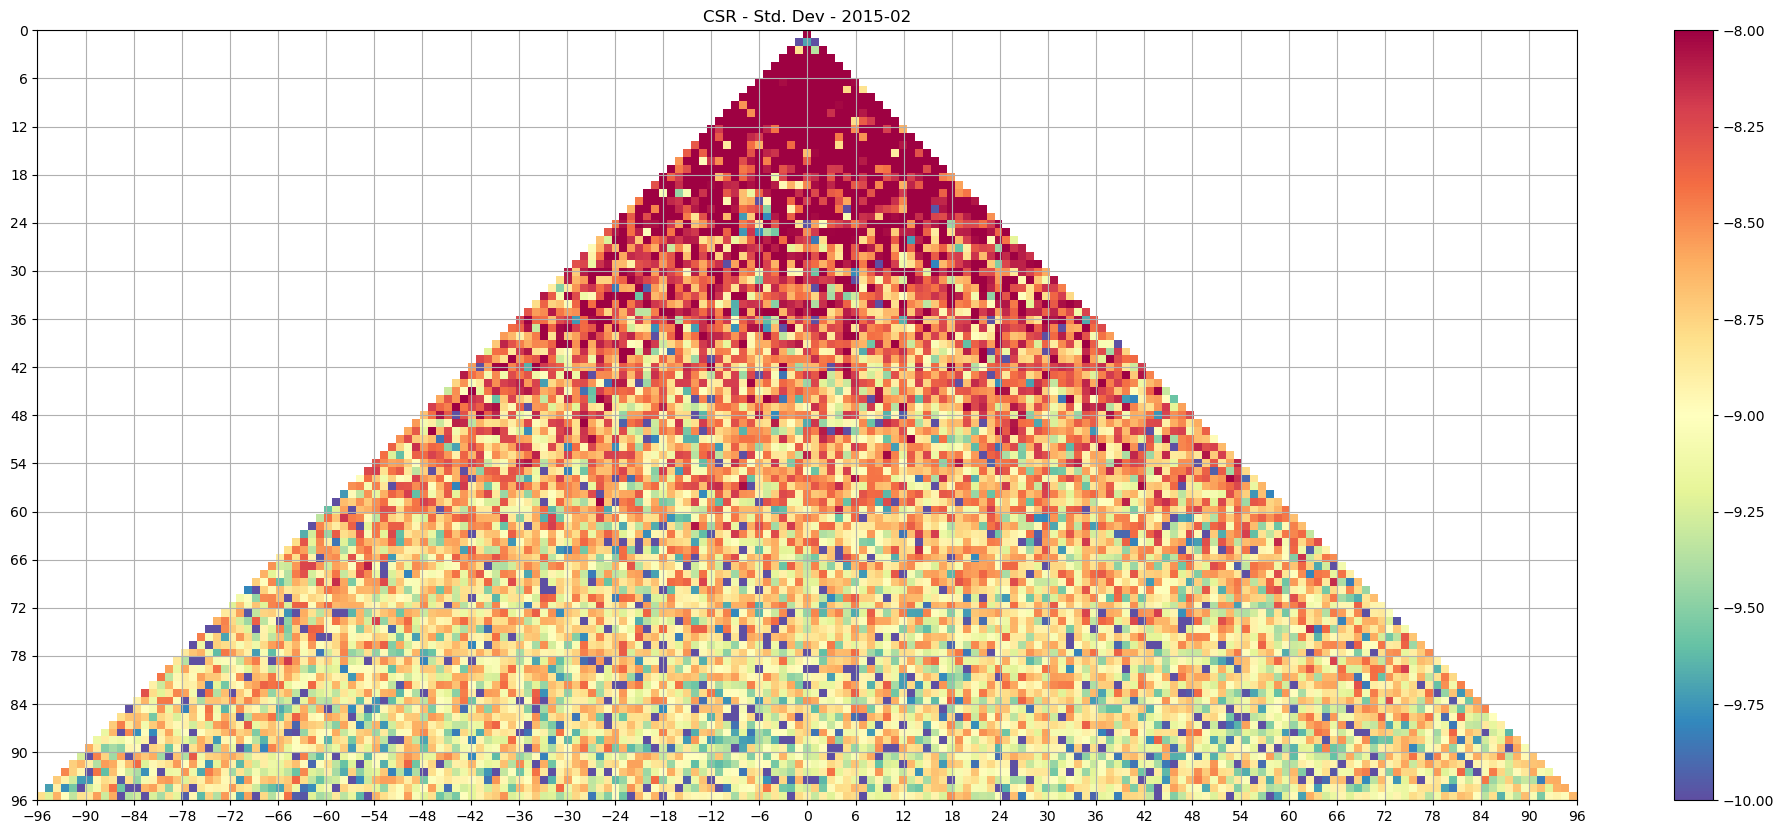

In [21]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(scmat_deck_itsg[145])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-10, vmax=-8)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_itsg[145]}")
plt.show()

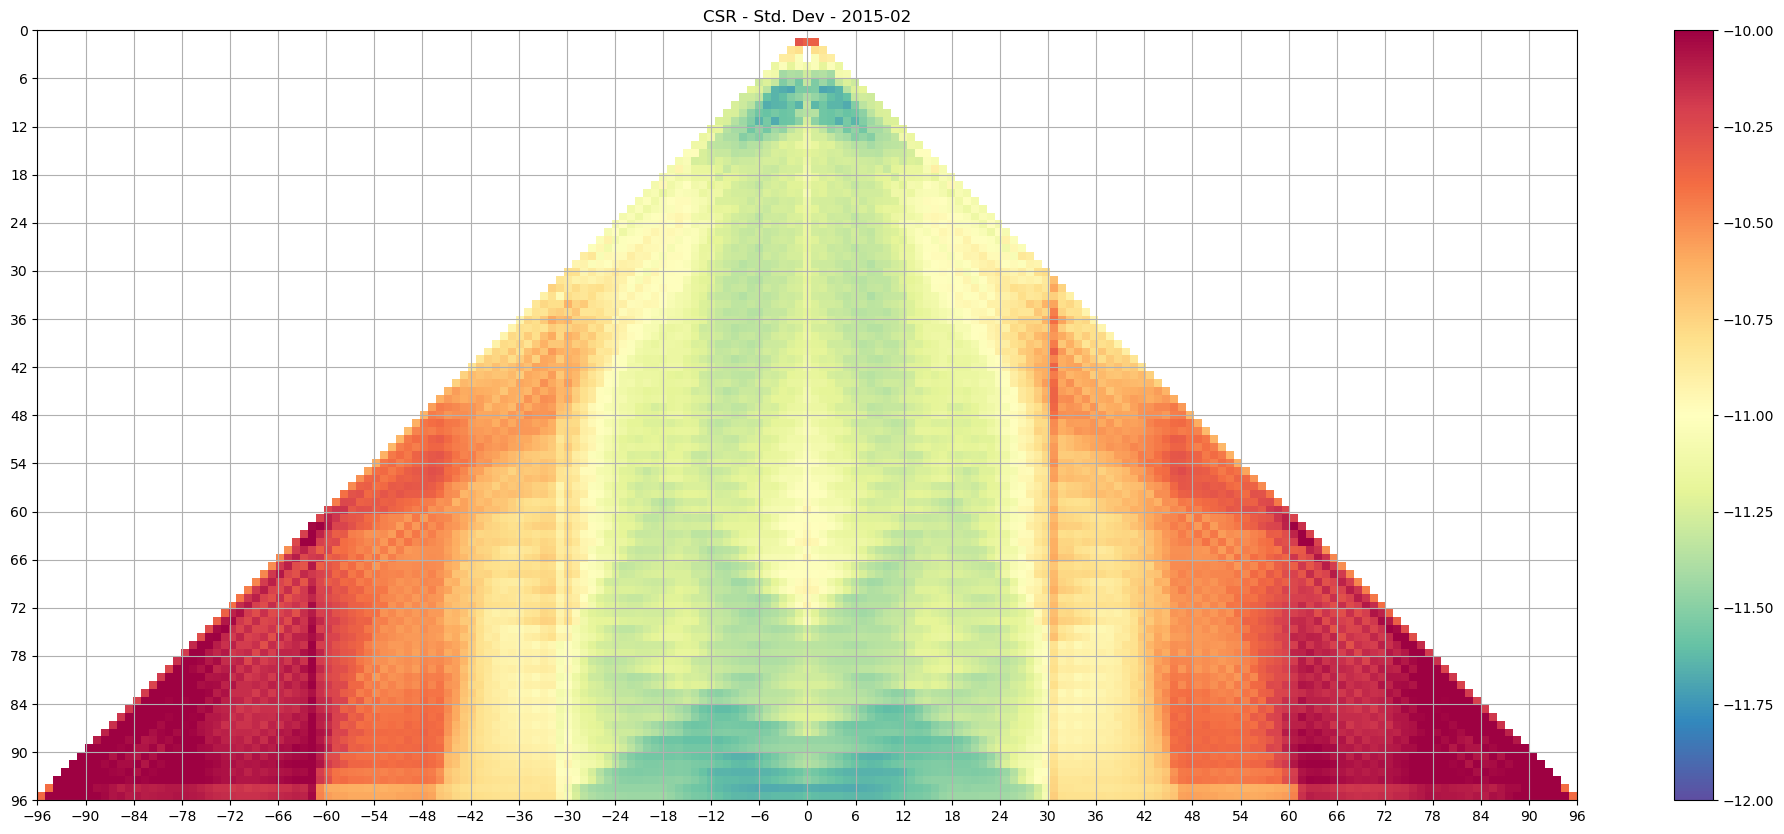

In [29]:

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_itsg[145])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_itsg[145]}")
plt.show()

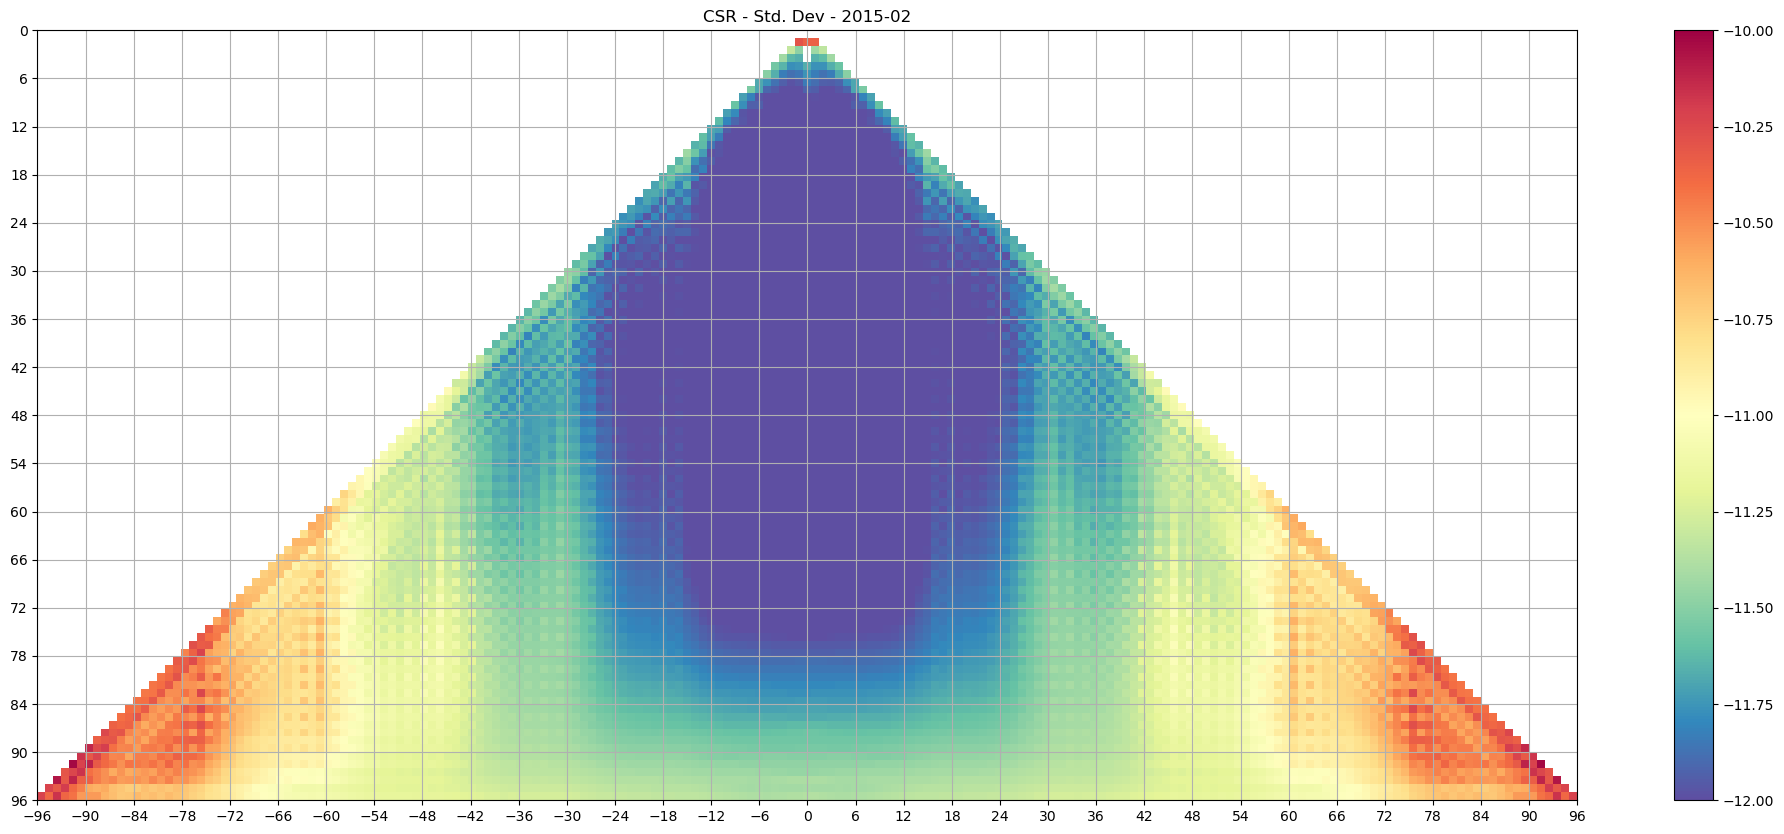

In [30]:

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_itsg[10])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_itsg[145]}")
plt.show()

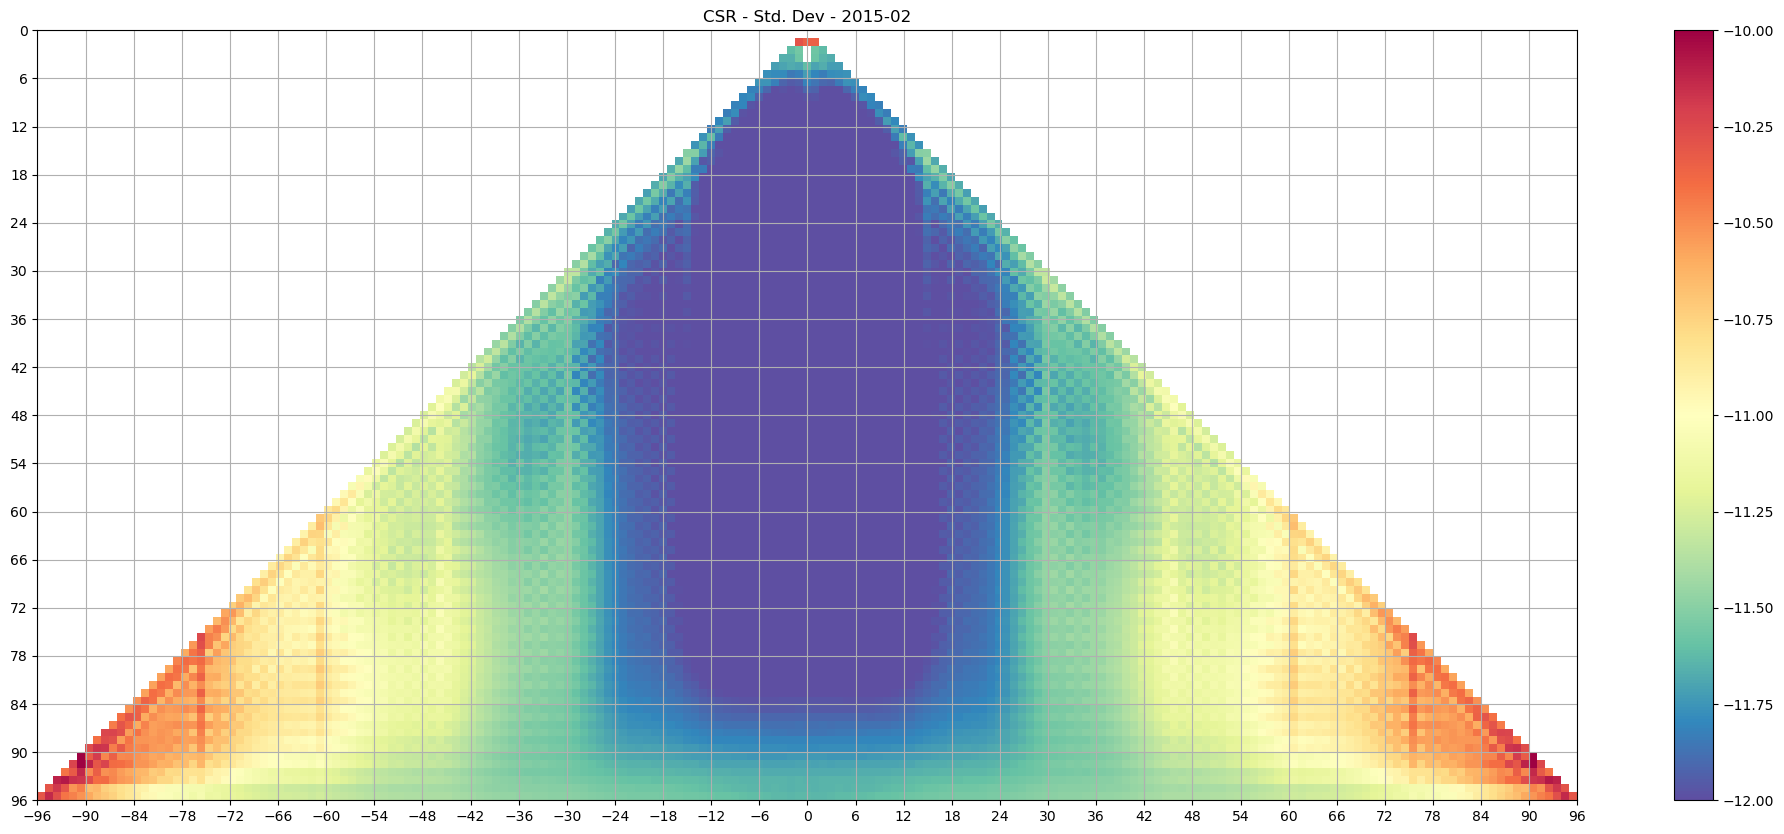

In [32]:

fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(devscmat_deck_itsg[190])), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_itsg[145]}")
plt.show()

## Using the current `clm2sc` functoin involving loops

In [36]:
Lmax = 96

sc_mat = np.zeros((Lmax+1, 2*Lmax + 2))



In [42]:
degree_order = int((Lmax+1) * (Lmax+2)/2)
clm = replaced_data_mat_itsg[10, :, 4]
slm = replaced_data_mat_itsg[10, :, 5]
degree = replaced_data_mat_itsg[10, :, 0]

for tile in range(0,int(len(degree)/degree_order), 1):
    i = 0
    for index1 in range(0,Lmax+1, 1):
        for index2 in range(0,index1+1, 1):
            
            sc_mat[index1, Lmax-index2] = slm[i + tile*degree_order]
            sc_mat[index1, Lmax+index2+1] = clm[i + tile*degree_order]
            i = i + 1


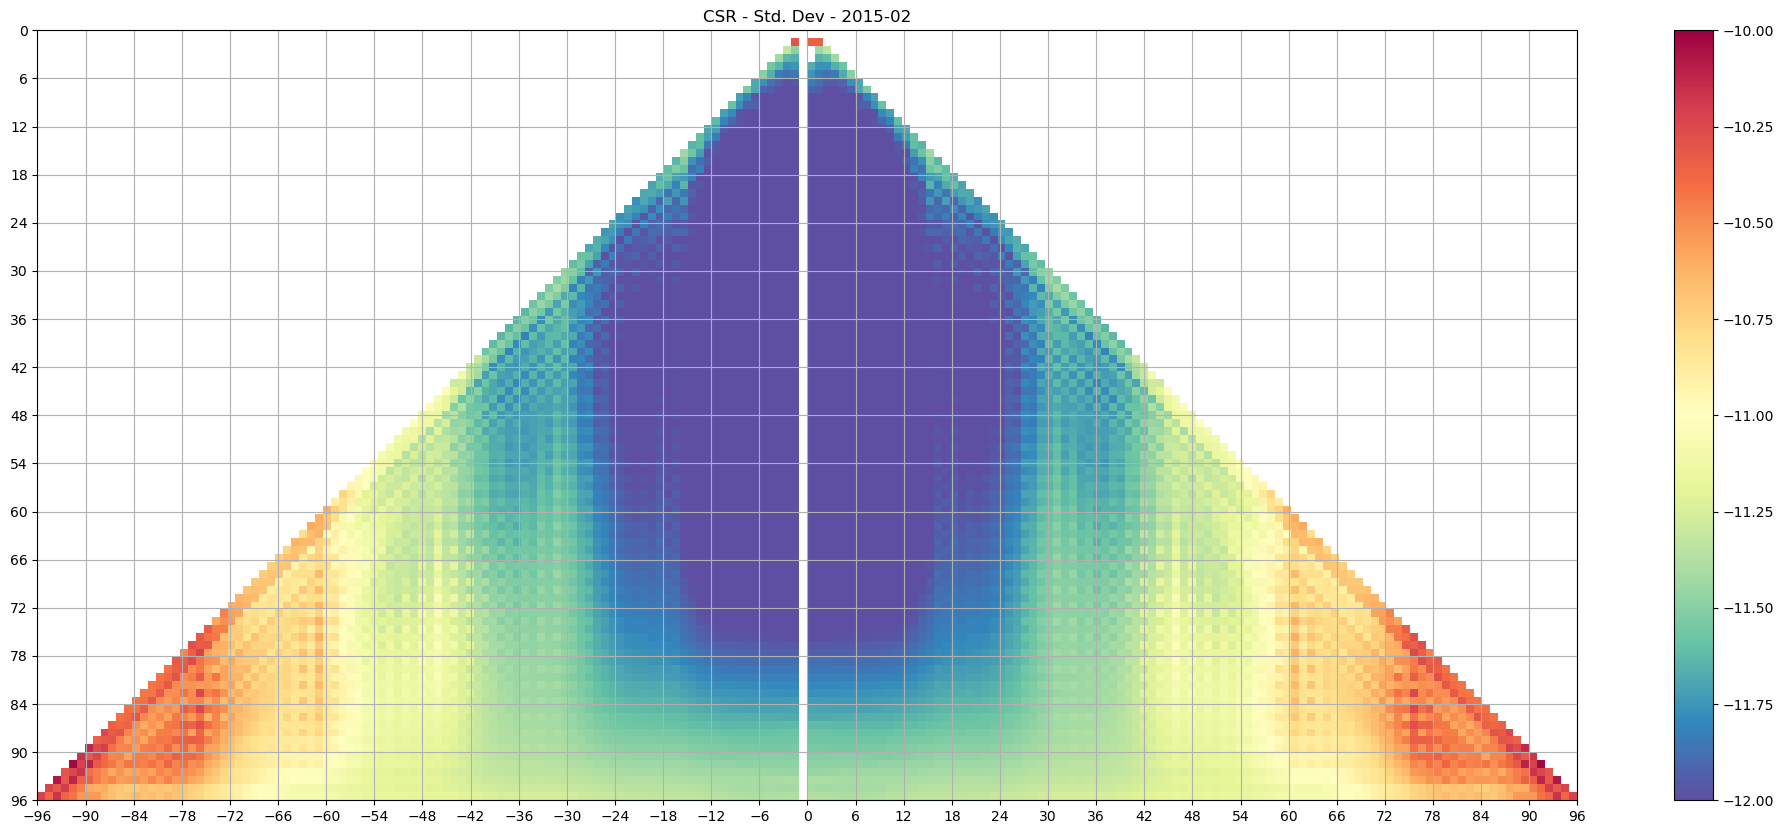

In [44]:
fig = plt.subplots(figsize=(25, 10))
plt.imshow(np.ma.log10(abs(sc_mat)), extent=[-96, 96, 96, 0], cmap='Spectral_r', vmin=-12, vmax=-10)
plt.grid()
# plt.colorbar()
x_vec = np.arange(-96, 96+1, 6)
y_vec = np.arange(96, -2, -6)

plt.xticks(x_vec,)
plt.yticks(y_vec)

plt.colorbar()
plt.title(f"CSR - Std. Dev - {dates_itsg[145]}")
plt.show()

## Identifying the source of problem
